## Correlazione tra Pil Pro Capite, positivi e decessi
### Il codice genera una matrice di correlazione tra  Pil Pro Capite, positivi e decessi. Oltre al dataset fornito, è stato creato un dataframe importando i dati relativi al Pil Pro Capite utilizzando il pacchetto BeautifulSoup. Sul dataframe creato con l'importazione del file csv è stato fatto un replace per accorpare i dati delle province autonome di Bolzano e Trento rinominandoli entrambi Trantino-Alto Adige in modo da rendere possibile il merge con l'altro dataframe e rendere i dati uniformati con le altre regioni. Inoltre all'interno del dataset i valori della colonna Deaths rappresentano i numero totale di decessi dall'inizio della pandemia; quindi per poter calcolare il numero totale dei decessi è stata presa in considerazione la differenza tra il valore Deaths con quello del giorno precedente.

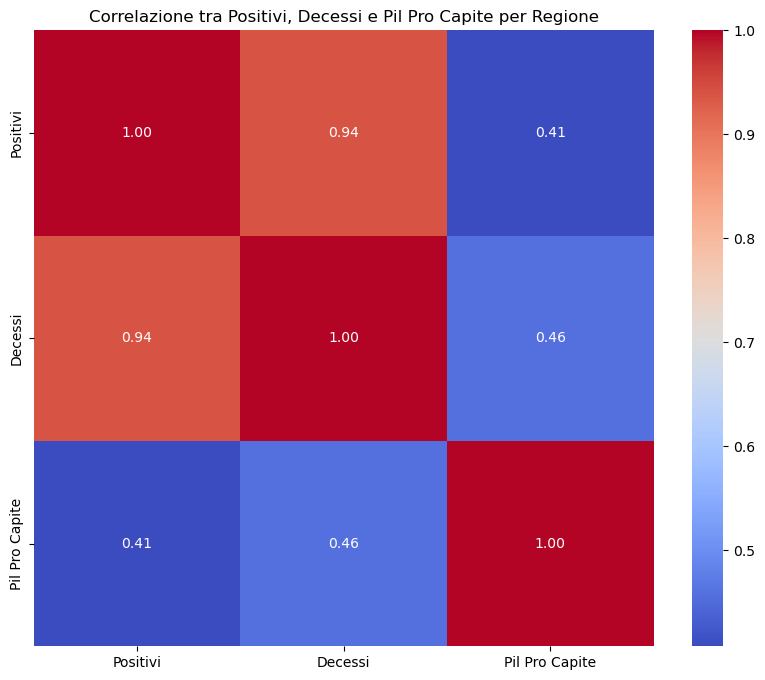

In [4]:
    import requests
    from bs4 import BeautifulSoup
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

# Carico e leggo il dataset delle regioni
    file_path_regione = 'covid19_italy_region _python.csv'
    df_regione = pd.read_csv(file_path_regione)

# Ordina il DataFrame per 'RegionName' e 'Date'
    df_regione = df_regione.sort_values(by=['RegionName', 'Date'])

# Calcola la differenza giornaliera per la colonna 'Deaths' raggruppata per 'RegionName'
    df_regione['DailyDeaths'] = df_regione.groupby('RegionName')['Deaths'].diff().fillna(df_regione['Deaths'])
    
# Aggiorna i valori nella colonna RegionName del DataFrame df_regione
    df_regione['RegionName'].replace({'P.A. Bolzano': 'Trentino Alto Adige', 'P.A. Trento': 'Trentino Alto Adige', 'Emilia-Romagna': 'Emilia Romagna'}, inplace=True)


# Somma totale del numero di decessi

    df_deaths = df_regione.groupby('RegionName')['DailyDeaths'].sum().reset_index()


# URL del sito per i dati del PIL pro capite
    url = 'https://www.trend-online.com/economia/pil-regioni-italiane-classifica/'

# Effettua la richiesta HTTP
    response = requests.get(url)


    # Parsing dell'HTML con BeautifulSoup
    soup = BeautifulSoup(response.text, 'html.parser')

    # Trova la tabella che contiene i dati sul PIL pro capite
    table = soup.find('table')

    # Estrai le righe della tabella
    rows = table.find_all('tr')

    # Inizializza una lista per i dati
    data_pil_pro_capite = []

    # Itera sulle righe della tabella, escludendo la prima riga delle intestazioni
    for row in rows[1:]:
        # Estrai le colonne
        cols = row.find_all('td')
        # Estrai i dati delle colonne desiderate (Regione e PIL pro capite)
        regione = cols[1].text.strip()
        pil_pro_capite = cols[2].text.strip()
        # Aggiungi i dati alla lista
        data_pil_pro_capite.append([regione, pil_pro_capite])

    # Crea un DataFrame pandas dai dati del PIL pro capite
    df_pil_pro_capite = pd.DataFrame(data_pil_pro_capite, columns=['Regione', 'PIL_pro_capite'])
    df_pil_pro_capite['Regione'].replace({'Friuli Venezia giulia': 'Friuli Venezia Giulia'}, inplace=True)

    # Normalizza  i dati del PIL pro capite usando lo Z-score
    pil_pro_capite_mean = df_pil_pro_capite['PIL_pro_capite'].astype(float).mean()
    pil_pro_capite_std = df_pil_pro_capite['PIL_pro_capite'].astype(float).std()
    df_pil_pro_capite['PIL_pro_capite_Normalizzato'] = (df_pil_pro_capite['PIL_pro_capite'].astype(float) - pil_pro_capite_mean) / pil_pro_capite_std

    # Somma dei nuovi casi positivi per regione
    df_new_cases = df_regione.groupby('RegionName')['NewPositiveCases'].sum().reset_index()

    # Calcola la media e la deviazione standard dei nuovi casi positivi
    new_cases_mean = df_new_cases['NewPositiveCases'].mean()
    new_cases_std = df_new_cases['NewPositiveCases'].std()

    # Applica la formula Z-score  per normalizzare i dati sui nuovi casi positivi
    df_new_cases['NewPositiveCases_Normalizzati'] = (df_new_cases['NewPositiveCases'] - new_cases_mean) / new_cases_std

    # Somma dei decessi per regione
    df_deaths = df_regione.groupby('RegionName')['DailyDeaths'].sum().reset_index()

    # Calcola la media e la deviazione standard dei decessi
    deaths_mean = df_deaths['DailyDeaths'].mean()
    deaths_std = df_deaths['DailyDeaths'].std()

    # Applica la formula Z-score per normalizzare i dati sui decessi
    df_deaths['Deaths_Normalizzati'] = (df_deaths['DailyDeaths'] - deaths_mean) / deaths_std

    # Unisci i DataFrame dei nuovi casi positivi, dei decessi e del PIL pro capite normalizzati
    df_merged = pd.merge(df_new_cases, df_deaths, on='RegionName')
    df_merged = pd.merge(df_merged, df_pil_pro_capite, left_on='RegionName', right_on='Regione')
    
    # Crea il grafico heatmap
    plt.figure(figsize=(10, 8))
    heatmap = sns.heatmap(df_merged[['NewPositiveCases_Normalizzati', 'Deaths_Normalizzati', 'PIL_pro_capite_Normalizzato']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlazione tra Positivi, Decessi e Pil Pro Capite per Regione')

    # Cambia le label dell'asse x e y del grafico heatmap
    heatmap.set_xticklabels(['Positivi', 'Decessi', 'Pil Pro Capite'])
    heatmap.set_yticklabels(['Positivi', 'Decessi', 'Pil Pro Capite'])
    
    # Salva il grafico come un'immagine PNG
    plt.savefig('CorrelazionePilProCapite.png')
    
    # Mostra il grafico
    plt.show()
    

